In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Needed Imports

import torch
import torch.nn as nn

import numpy as np
import torch.autograd as autograd
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from pathlib import Path

from random import randint
from IPython.display import Image

In [3]:
import matplotlib.pyplot as plt

In [4]:
# Used Parameters

# Best Model in my opinion are with these parameters and the full data
# Atleast for this architecture
# a fully connected model seemed to work best for others but I tried to improve on this CNN
# architecture for as much as possible

lr= 20e-4
epochs = 100
resultion = (64,64)
load_model = True
train = False


In [5]:
# Paths to save the model and images later

path = f'vae_{lr}_{epochs}_{resultion}'
path2 = f'vae_{lr}_{100}_{resultion}'
path

'vae_0.002_100_(64, 64)'

In [6]:
# Path to the dataset

# dataset_path = Path.cwd().joinpath('data/pixelchars')
dataset_path = Path.cwd().joinpath('data/front') # To only have the front view

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [7]:
#Set where to save the model
model_path = Path.cwd().joinpath('models',f'{path}.pth')
model_path2 = Path.cwd().joinpath('models',f'{path2}.pth')
model_path

WindowsPath('B:/DHBW/learning_ai/VAE/models/vae_0.002_100_(64, 64).pth')

In [8]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Transform the pixelcharacters und get them into a Batchloader

transform = transforms.Compose([
        transforms.Resize(resultion),
        transforms.ToTensor()
])

batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True}

data = ImageFolder(root=dataset_path, transform=transform)

loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, **kwargs)

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [10]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [11]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, resultion=(64,64)):
        super(VAE, self).__init__()
        
        # The Input shape forming from the resultion and the used color channels
        self.input_shape = (image_channels, ) + resultion
        
        # The encoder build from a sequence of convultion and one flatten layer
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        # A function to get the shape after the flatten layer dynamically
        self.encoded_shape = self.feature_size()
        
        # Three sequences of fully connected layers to calculate mu and logvar for encoding
        # and later z for decoding before feeding it into the decoder
        self.fc1 = nn.Sequential(
                        nn.Linear(self.encoded_shape, 128),
                        nn.ReLU(),
                        nn.Linear(128, 32)
        )
        self.fc2 = nn.Sequential(
                        nn.Linear(self.encoded_shape, 128),
                        nn.ReLU(),
                        nn.Linear(128, 32)
        )
        self.fc3 = nn.Sequential(
                        nn.Linear(32, 128),
                        nn.ReLU(),
                        nn.Linear(128, self.encoded_shape)
        )
        
        # The transposed convultion layers used to generate a image from the encoded output
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(self.encoded_shape, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    # Reparametrisierung die es uns jetzt ermöglicht eine Backpropagation durchführen kann
    # Reparametrisierungstrick
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        #print([a for a in x])
        h = self.encoder(x)
        #print("h",h)
        z, mu, logvar = self.bottleneck(h)
        #print("z",z)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
    
    def initialize_weights(self, layer):
        """initalizes the weights and biases
        initalizes the weights and biases in case there was no state_dict provided to load them from
        model_apply() iterativly goes through every layer and calls this methode
        
        Args:
            layer (nn.Layer): the layer to be initalized
        """
        # gain = nn.init.calculate_gain(self.cfg.nonlinearity)
        init_weight = 'xavier_uniform'
        gain = 1

        if init_weight == 'orthogonal':
            if type(layer) == nn.Conv2d:
                nn.init.orthogonal_(layer.weight.data, gain=gain)
            elif type(layer) == nn.Linear:
                nn.init.orthogonal_(layer.weight.data, gain=gain)
                layer.bias.data.fill_(0)
            else:
                pass
        elif init_weight == 'xavier_uniform':
            if type(layer) == nn.Conv2d:
                nn.init.xavier_uniform_(layer.weight.data, gain=gain)

            elif type(layer) == nn.Linear:
                nn.init.xavier_uniform_(layer.weight.data, gain=gain)
                layer.bias.data.fill_(0)

            else:
                pass
            
    def feature_size(self):
        """dynamically sets the dimension of the first linear Layer
        
        by calling this a forward pass through the layers definied in features is performed
        and the resulting output_size can be used in the first linear Layer. Effectivly making
        the net independend of the chosen resultion
        Returns:
            int: size of the flattend ccn output before linear layers
        """
        
        return self.encoder(autograd.Variable(torch.zeros(1, * self.input_shape))).view(1, -1).size(1)

In [12]:
fixed_x, _ = next(iter(loader))
image_channels = fixed_x.size(1)

In [13]:
model = VAE(image_channels=image_channels, resultion=resultion).to(device)

if load_model:
    print("Loading model from: ", model_path)
    model.load_state_dict(torch.load(model_path))
else:
    # Applies a inital weight to Conv and Linear Layers
    # Currently Xavier Uniform. Orthogonal is also implemented
    model.apply(model.initialize_weights)

Loading model from:  B:\DHBW\learning_ai\VAE\models\vae_0.002_100_(64, 64).pth


<All keys matched successfully>

In [14]:
model_cfg = Path.cwd().joinpath('models',f'{path}.txt')
with open(model_cfg, 'w') as f:
    f.write(model.__str__())

1243

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

In [17]:
import torch.nn.functional as F
def loss_fn(recon_x, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    # Kullback-Leibler-Divergenz zur Ähnlichkeit zweier Verteilungen
    # Konvergiert gegen eine Normalverteilung im latenten Raum
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD, BCE, KLD

In [18]:
if train:
    for epoch in range(epochs):
        for idx, (images, _) in enumerate(loader):
            #for image in images:
            #    print(torch.isinf(image))
            #print(idx)
            images = images.to(device)
            #try:
            recon_images, mu, logvar = model(images)

                #if recon_images == None:
                #    continue
            loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
            #except(RuntimeError):
            #    print(f"idx:{idx},images: {images},labels{_}\n\nrecon{recon_images}")
            #    hallo + 3

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data/batch_size, bce.data/batch_size, kld.data/batch_size)
        print(to_print)

    torch.save(model.state_dict(), model_path)

In [19]:
def compare(x):
    # simple function to get a single pixelchar with its decoded counterpart
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

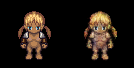

In [20]:
fixed_x = data[randint(500, 700)][0].unsqueeze(0)
compare_x = compare(fixed_x.to(device))

image_path = Path.cwd().joinpath('images','decoded',f'{path}.png')
save_image(compare_x.data.cpu(), image_path)
display(Image(image_path, width=700, unconfined=True))

In [21]:
with torch.no_grad():
    # generate random noise and decode a pixelchar from there
    noise = torch.randn(batch_size, 32).to(device)
    generated_images = model.decode(noise)

In [22]:
import torchvision
def imshow(img, idx=[0, 300, 0, 300]):
    fig = plt.figure()
    #img = img / 2 + 0.5     # unnormalize
    try:
        npimg = img.cpu().numpy()
        
    except:
        npimg = img.numpy()
    
    
    print(npimg.shape)
    print(np.transpose(npimg, (1, 2, 0)).shape)
        
    plt.imshow(np.transpose(npimg, (1, 2, 0))[idx[0]:idx[1], idx[2]:idx[3], :])
    #plt.imshow(npimg)
    plt.show()

(3, 860, 530)
(860, 530, 3)


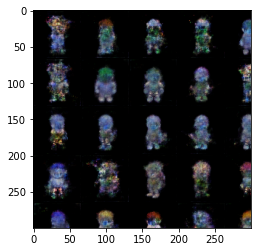

In [23]:
generated_images = generated_images.reshape((100, 3, 64, 64))
imshow(torchvision.utils.make_grid(generated_images))
image_path = Path.cwd().joinpath('images','generated',f'{path}.png')
save_image(generated_images.data.cpu(), image_path)